# SmartBank Customer Churn Analysis
### Lloyds Banking Group "Customer Retention Enhancement through Predictive Analytics" Initiative
### Analysis by: Breanna Williams
#### November 28, 2025

---
### Overview

This notebook contains the exploratory data analysis (EDA) and preprocessing steps for a Customer Churn Analysis for SmartBank. The goal of this project is to analyze customer data to identify patterns and factors that contribute to customer churn. The data was collected from the banks internal database and included demographic information, account activity, transaction history, customer churn, and customer service interactions. 

We performed EDA to understand the data distribution, identify missing values, and explore relationships between variables. Following EDA, we implemented preprocessing steps such as handling missing values, encoding categorical variables, scaling numerical features.

We found that that univariate analysis provided limited insights into churn predictors, indicating the need for multivariate modeling to uncover complex relationships.

---
### Necessary Libraries and Imports

In [55]:
# Base imports
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


# Stats imports
import scipy.stats.stats as stats
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn imports
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler, PowerTransformer, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

---
### Load Data

In [56]:
churn_status = pd.read_csv('../data/Customer_Churn_Data_Large(Churn_Status).csv')
customer_demographics = pd.read_csv('../data/Customer_Churn_Data_Large(Customer_Demographics).csv')
customer_service = pd.read_csv('../data/Customer_Churn_Data_Large(Customer_Service).csv')
online_activity = pd.read_csv('../data/Customer_Churn_Data_Large(Online_Activity).csv')
transaction_history = pd.read_csv('../data/Customer_Churn_Data_Large(Transaction_History).csv')

In [57]:
def transform_customer_service(customer_service):
    """
    Transforms the highly granular customer_service dataframe by:
     1. Encoding ResolutionStatus as binary,
     2. Grouping by CustomerID,
     3. Replacing individual interaction dates with DaysSinceLastInteraction and,
     4. Calculating new column ResolutionRate.
    """
    # Binarize resolution status for grouping 
    customer_service['ResolutionStatus'] = customer_service['ResolutionStatus'].replace({'Unresolved': 0, 'Resolved': 1})

    # Convert InteractionDate to datetime
    customer_service['InteractionDate'] = pd.to_datetime(customer_service['InteractionDate'])

    # Group customer_service by CustomerID
    customer_service = customer_service.groupby('CustomerID').agg({
                                                'InteractionID': 'count',           # Number of interactions
                                                'InteractionDate': 'max',
                                                'ResolutionStatus': 'sum'           # Number of resolved interactions
                                                }).reset_index().rename(columns={
                                                'InteractionID': 'NumInteractions', 
                                                'ResolutionStatus': 'InteractionsResolved'}) 

    # Calculate DaysSinceLastInteraction
    max_int_date = customer_service['InteractionDate'].max()
    customer_service['DaysSinceLastInteraction'] = (max_int_date - customer_service['InteractionDate']).dt.days

    # Creating a new column to indicate the rate of interactions resolved
    customer_service['ResolutionRate'] = round(customer_service['InteractionsResolved'] / customer_service['NumInteractions'], 2)

    # Drop raw date column
    customer_service.drop(columns=['InteractionDate', 'NumInteractions', 'InteractionsResolved'], inplace=True)     

    return customer_service


In [58]:
# Applying the customer service transformation function
customer_service = transform_customer_service(customer_service)
customer_service.head()

,CustomerID,DaysSinceLastInteraction,ResolutionRate
0,1,274,1.0
1,2,288,1.0
2,3,128,1.0
3,4,42,0.5
4,6,239,1.0


Customer Service Data Transformation:

We gathered customer service interaction data from SmartBank. This dataset contains detailed records of customer interactions, including dates, types of interactions, and resolution statuses.

- InteractionID and ResolutionStatus are aggregated and dropped in favor of ResolutionRate indicating the proportion of interactions resolved.
- InteractionDate is transformed into DaysSinceLastInteraction, indicating how recently the customer last interacted with customer service. More recent interactions could signal higher engagement or potential issues.
- InteractionType is left out because NumInteractions already captures the volume of interactions.

In [59]:
def transform_online_activity(online_activity):
    """    
    Transforms online_activity dataframe by:
     1. Grouping by CustomerID,
     2. Replacing LastLoginDate with DaysSinceLastLogin and,
     3. Encoding ServiceUsage as dummy variables.
     """
    
    # Get dummies for ServiceUsage so we can aggregate later if needed
    online_activity = pd.get_dummies(online_activity, columns=['ServiceUsage'], drop_first=True)

    # Convert LastLoginDate to datetime
    online_activity['LastLoginDate'] = pd.to_datetime(online_activity['LastLoginDate'])

    # Group online_activity by CustomerID
    online_activity = online_activity.groupby('CustomerID').agg({'LastLoginDate': 'max',
                                                                 'LoginFrequency': 'max',
                                                                 'ServiceUsage_Online Banking': 'sum',
                                                                 'ServiceUsage_Website': 'sum'}).reset_index()

    # Add column for days since last login instead of using raw dates
    max_log_date = online_activity['LastLoginDate'].max()
    online_activity['DaysSinceLastLogin'] = (max_log_date - online_activity['LastLoginDate']).dt.days
    online_activity.drop(columns=['LastLoginDate'], inplace=True)     # Drop raw date column

    return online_activity

In [60]:
online_activity = transform_online_activity(online_activity)
online_activity.head()

,CustomerID,LoginFrequency,ServiceUsage_Online Banking,ServiceUsage_Website,DaysSinceLastLogin
0,1,34,0,0,71
1,2,5,0,1,26
2,3,3,0,1,46
3,4,2,0,1,128
4,5,41,0,1,65


Online Activity Data Transformation:

We gathered online activity data from SmartBank. This dataset contains detailed records of login history, frequency, and types of online services used.

- LastLoginDate is transformed into DaysSinceLastLogin, indicating how recently the customer last logged into their online banking. More recent logins could signal higher engagement or lower churn risk.
- ServiceUsage is converted into multiple binary columns using one-hot encoding, allowing us to capture the variety of services used by each customer without losing information due to aggregation.


In [61]:
def transform_transaction_history(transaction_history):
    """ 
    Transforms the highly granular transaction_history dataframe by:
     1. Getting dummies for ProductCategory,
     2. Grouping by CustomerID and,
     3. Replacing TransactionDate with DaysSinceLastTransaction.
    """

    # Convert TransactionDate to datetime
    transaction_history['TransactionDate'] = pd.to_datetime(transaction_history['TransactionDate'])
    
    # Group transaction_history by CustomerID
    transaction_history = transaction_history.groupby('CustomerID').agg({
                                                    'TransactionID': 'count',
                                                    'AmountSpent': 'sum',
                                                    'TransactionDate': 'max',
                                                    }).reset_index().rename(columns={'TransactionID': 'NumTransactions'})

    # Add column for days since last transaction instead of using raw dates
    max_date = transaction_history['TransactionDate'].max()
    transaction_history['DaysSinceLastTransaction'] = (max_date - transaction_history['TransactionDate']).dt.days
    transaction_history.drop(columns=['TransactionDate'], inplace=True)     # Drop raw date column
    
    return transaction_history

In [62]:
transaction_history = transform_transaction_history(transaction_history)
transaction_history.head()

,CustomerID,NumTransactions,AmountSpent,DaysSinceLastTransaction
0,1,1,416.50,279
1,2,7,1547.42,42
2,3,6,1702.98,84
3,4,5,917.29,4
4,5,8,2001.49,10


Transaction History Data Transformation:

We gathered transaction history data from SmartBank. This dataset contains detailed records of customer spending activity.

- TransactionID is converted to NumTransactions. 
- AmountSpent is kept.
- TransactionDate is transformed into DaysSinceLastTransaction, indicating how recently the customer last made a transaction. More recent transactions could indicate higher engagement or lower churn risk.
- ProductCategory is left out because NumTransactions already captures the volume of transactions.

In [63]:
def merge_data(churn_status, customer_demographics, customer_service, online_activity, transaction_history):
    """ Merge datasets. """
    # Merge data
    data = churn_status.merge(customer_demographics, on='CustomerID', how='outer')
    data = data.merge(customer_service, on='CustomerID', how='outer')
    data = data.merge(online_activity, on='CustomerID', how='outer')
    data = data.merge(transaction_history, on='CustomerID', how='outer')

    return data

In [64]:
data = merge_data(churn_status, customer_demographics, customer_service, online_activity, transaction_history)
data.head()

,CustomerID,ChurnStatus,Age,Gender,MaritalStatus,IncomeLevel,DaysSinceLastInteraction,ResolutionRate,LoginFrequency,ServiceUsage_Online Banking,ServiceUsage_Website,DaysSinceLastLogin,NumTransactions,AmountSpent,DaysSinceLastTransaction
0,1,0,62,M,Single,Low,274.0,1.0,34,0,0,71,1,416.50,279
1,2,1,65,M,Married,Low,288.0,1.0,5,0,1,26,7,1547.42,42
2,3,0,18,M,Single,Low,128.0,1.0,3,0,1,46,6,1702.98,84
3,4,0,21,M,Widowed,Low,42.0,0.5,2,0,1,128,5,917.29,4
4,5,0,21,M,Divorced,Medium,NaN,NaN,41,0,1,65,8,2001.49,10


---
### Clean Data

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   1000 non-null   int64  
 1   ChurnStatus                  1000 non-null   int64  
 2   Age                          1000 non-null   int64  
 3   Gender                       1000 non-null   object 
 4   MaritalStatus                1000 non-null   object 
 5   IncomeLevel                  1000 non-null   object 
 6   DaysSinceLastInteraction     668 non-null    float64
 7   ResolutionRate               668 non-null    float64
 8   LoginFrequency               1000 non-null   int64  
 9   ServiceUsage_Online Banking  1000 non-null   int64  
 10  ServiceUsage_Website         1000 non-null   int64  
 11  DaysSinceLastLogin           1000 non-null   int64  
 12  NumTransactions              1000 non-null   int64  
 13  AmountSpent        

In [66]:
# Checking for duplicates
data.duplicated().sum()

0

In [67]:
# Let's handle NA's
data[['ResolutionRate','DaysSinceLastInteraction']] = data[['ResolutionRate','DaysSinceLastInteraction']].fillna({
    'ResolutionRate': -1,                # -1 indicates no interactions
    'DaysSinceLastInteraction': -1,      # -1 days since last interaction means no interactions
})

In [68]:
# Let's change the data types of certain columns for better analysis.
data[['DaysSinceLastInteraction']] = data[['DaysSinceLastInteraction']].astype('int64')

In [69]:
# Rechecking the data info after handling NA's and changing data types  
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   1000 non-null   int64  
 1   ChurnStatus                  1000 non-null   int64  
 2   Age                          1000 non-null   int64  
 3   Gender                       1000 non-null   object 
 4   MaritalStatus                1000 non-null   object 
 5   IncomeLevel                  1000 non-null   object 
 6   DaysSinceLastInteraction     1000 non-null   int64  
 7   ResolutionRate               1000 non-null   float64
 8   LoginFrequency               1000 non-null   int64  
 9   ServiceUsage_Online Banking  1000 non-null   int64  
 10  ServiceUsage_Website         1000 non-null   int64  
 11  DaysSinceLastLogin           1000 non-null   int64  
 12  NumTransactions              1000 non-null   int64  
 13  AmountSpent        

Insights:
- The dataset contains 1000 records and 14 features.
- There were nulls present in ResolutionRate and DaysSinceLastInteraction. These were handled now because the nulls are a consequence of merging and feature engineering, not original data issues. This would not be possible in later preprocessing steps.
- ResolutionRate nulls were filled with -1 to indicate no interactions.
- DaysSinceLastInteraction nulls were filled with -1 to indicate no interactions.
- There were no duplicate records.
- There are 2 float datas types, 9 integer data types, and 3 object data types. DaysSinceLastInteraction was converted to integer.

---
### Univariate Statistical(Regression) Analysis
- H0: There is no association between the featurn and the target variable('CustomerChurn').

- H1: There is an association between the feature and the target variable('CustomerChurn').

- Significance Level: 0.05

In [70]:
results = []
for col in data.columns:
    if col != 'ChurnStatus':
        if data[col].dtype in ['int64', 'float64']:
            X = sm.add_constant(data[col])
            y = data['ChurnStatus']
            model = sm.Logit(y, X).fit(disp=0)      # disp=0 to suppress output
            p_value = model.pvalues[1]              # p-value for the predictor for significance
            odds_ratio = np.exp(model.params[1])    # This is the effect size
            if p_value < 0.05:
                results.append({'column': col, 'p_value': p_value.round(4), 'odds_ratio': odds_ratio.round(4)})
        elif data[col].dtype == 'object':
            dummies = pd.get_dummies(data[col], prefix=col, drop_first=True, dtype='int64')
            for dummy_col in dummies.columns:
                X = sm.add_constant(dummies[dummy_col])
                y = data['ChurnStatus']
                model = sm.Logit(y, X).fit(disp=0)
                p_value = model.pvalues[1]
                odds_ratio = np.exp(model.params[1])
                if p_value < 0.05:
                    results.append({'column': dummy_col, 'p_value': p_value.round(4), 'odds_ratio': odds_ratio.round(4)})
pd.DataFrame(results).sort_values(by=['odds_ratio', 'p_value'], ascending=[False, True]).reset_index(drop=True)


,column,p_value,odds_ratio
0,DaysSinceLastInteraction,0.0021,1.0022
1,LoginFrequency,0.0101,0.9857


Insights:

There is a 0.0021 probability of observing our data, or something more extreme, if the null hypotheses is true. Therefore we reject the null hypothesis for NumInteractions.

There is a 0.0101 probability of observing our data, or something more extreme, if the null hypotheses is true. Therefore we reject the null hypothesis for DaysSinceLastInteraction.

We fail to reject the null hypothesis for all other variables as their p-values were above the 0.05 significance level.

Explanation:
- There were only two variables with significant p-values (< 0.05):
    1. NumInteractions (p-value: 0.0021)
    2. DaysSinceLastInteraction (p-value: 0.0101)
- The odds ratios (effect sizes) for these variables were extremely weak:
    - NumInteractions: 1.0022, indicating a slight increase (0.22%) in churn odds for each additional interaction.
    - DaysSinceLastInteraction: 0.9857, indicating a slight decrease in churn odds (1.43%) for each additional day since the last interaction.
- It is likely that churn is influenced by a combination of factors rather than any single variable, as no individual predictor showed a strong effect on its own. We will need to explore multivariate models during our modeling phase to better understand the drivers of churn.


---
### Exploratory Data Analysis (EDA)

In [71]:
# Seperating columns by type for easier analysis

target = 'ChurnStatus'

numeric_columns = [
 'ResolutionRate',
 'DaysSinceLastInteraction',
 'LoginFrequency',
 'DaysSinceLastLogin',
 'NumTransactions',
 'DaysSinceLastTransaction',
 'AmountSpent',
 'ServiceUsage_Online Banking',
 'ServiceUsage_Website',
 'Age'                          
 ]

nominal_columns =[ 
 'Gender',
 'MaritalStatus']

ordinal_columns = [
 'IncomeLevel']

categorical_columns = nominal_columns + ordinal_columns

#### Target Variable (ChurnStatus)

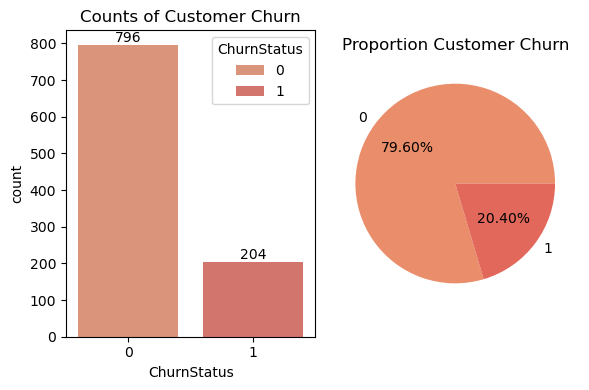

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(6,4))

sns.countplot(data=data, x=target, hue=target, ax=axs[0], palette=sns.color_palette('flare'))
for container in axs[0].containers:     # Loop needed when hue is used.
    axs[0].bar_label(container)
axs[0].set_title('Counts of Customer Churn')


counts = data[target].value_counts()
axs[1].pie(counts, labels=counts.index, autopct='%0.2f%%', colors=sns.color_palette('flare'))
axs[1].set_title('Proportion Customer Churn')

plt.tight_layout()
plt.show()

- The target variable is unbalanced as evidenced by an over 60% difference between customer's who churned and those who did not churn.
- We will need to address this before modelling.

#### Numeric Variables
We will:
1. Examine the distribution and summary statistics of each numeric variable.
2. Check for molticollinearity among numeric predictors.
3. Visualize relationships between numeric predictors and the target variable.

In [73]:
# Summary of numeric columns
data[numeric_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ResolutionRate               1000 non-null   float64
 1   DaysSinceLastInteraction     1000 non-null   int64  
 2   LoginFrequency               1000 non-null   int64  
 3   DaysSinceLastLogin           1000 non-null   int64  
 4   NumTransactions              1000 non-null   int64  
 5   DaysSinceLastTransaction     1000 non-null   int64  
 6   AmountSpent                  1000 non-null   float64
 7   ServiceUsage_Online Banking  1000 non-null   int64  
 8   ServiceUsage_Website         1000 non-null   int64  
 9   Age                          1000 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 78.2 KB


In [74]:
data[numeric_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
ResolutionRate,1000.0,0.02050,0.798102,-1.0,-1.000,0.00,1.0000,1.00
DaysSinceLastInteraction,1000.0,100.62700,107.534569,-1.0,-1.000,64.50,184.2500,359.00
LoginFrequency,1000.0,25.91200,14.055953,1.0,13.750,27.00,38.0000,49.00
DaysSinceLastLogin,1000.0,178.10500,104.897299,0.0,90.750,173.50,267.0000,364.00
NumTransactions,1000.0,5.05400,2.603433,1.0,3.000,5.00,7.0000,9.00
DaysSinceLastTransaction,1000.0,78.05100,78.720654,0.0,20.000,52.00,106.0000,355.00
AmountSpent,1000.0,1267.07495,738.590013,9.8,626.685,1232.88,1791.9025,3386.04
ServiceUsage_Online Banking,1000.0,0.34900,0.476892,0.0,0.000,0.00,1.0000,1.00
ServiceUsage_Website,1000.0,0.30900,0.462312,0.0,0.000,0.00,1.0000,1.00
Age,1000.0,43.26700,15.242311,18.0,30.000,43.00,56.0000,69.00


- The variables have varying distributions and ranges, indicating the need for normalization before modeling.

In [75]:
# Checking the skewness

skewness = []
for col in data[numeric_columns].columns:
    skew = data[col].skew()
    skewness.append({'column': col, 'skew': skew, 'direction': 'right' if skew > 0 else 'left',
                         'distribution': 'approximately normal' if abs(skew) < 0.5 else 'moderately skewed' if abs(skew) < 1 else 'highly skewed'})

pd.DataFrame(skewness)

,column,skew,direction,distribution
0,ResolutionRate,-0.178099,left,approximately normal
1,DaysSinceLastInteraction,0.725002,right,moderately skewed
2,LoginFrequency,-0.127877,left,approximately normal
3,DaysSinceLastLogin,0.080321,right,approximately normal
4,NumTransactions,-0.058949,left,approximately normal
5,DaysSinceLastTransaction,1.496163,right,highly skewed
6,AmountSpent,0.269911,right,approximately normal
7,ServiceUsage_Online Banking,0.634536,right,moderately skewed
8,ServiceUsage_Website,0.827937,right,moderately skewed
9,Age,0.013168,right,approximately normal


- 6 of the 10 numeric variables are approximately normally skewed. The three that are not may require transformation for linear models.
- 7 of the 10 numeric variables are right-skewed, indicating that most customers have lower values with a few having very high values. This may require log/Box-Cox/PowerTransformer transformations for modeling.

<Axes: >

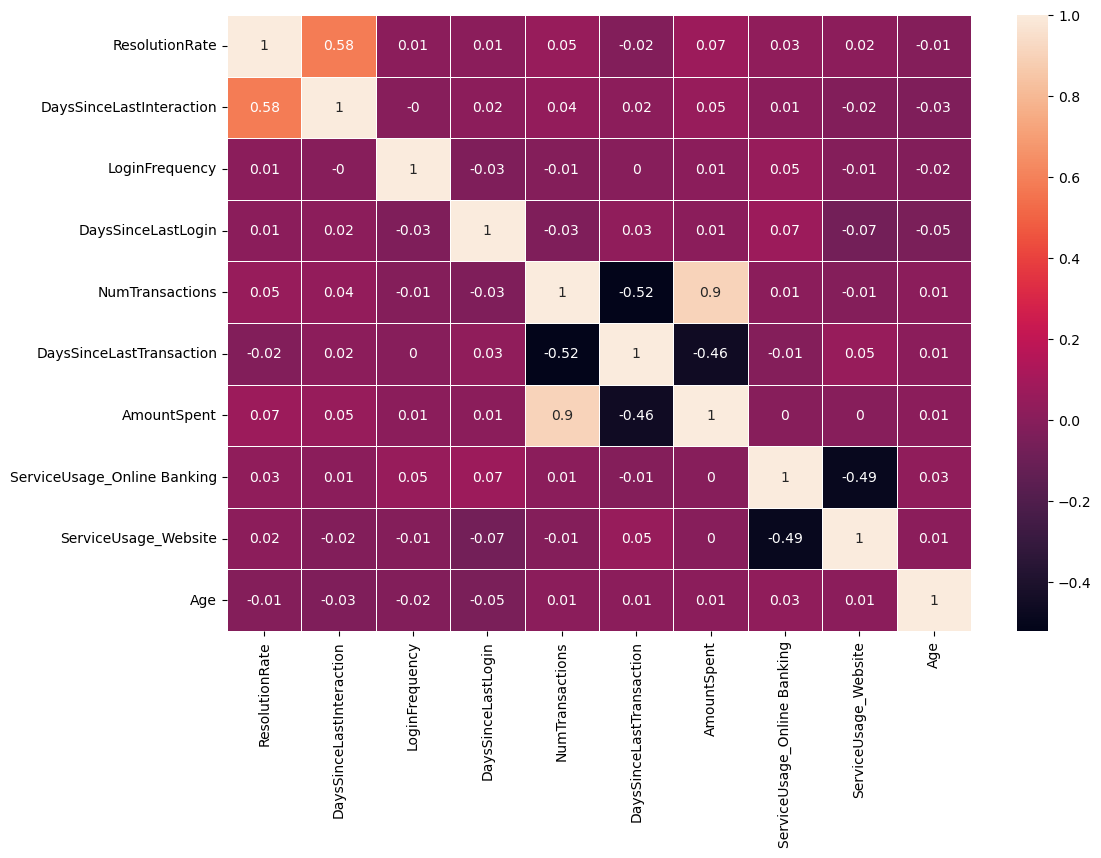

In [76]:
# Creating a heat map to check for multicollinearity between variables

correlation_matrix = data[numeric_columns].corr().round(2)

plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, linewidths=0.5)

In [77]:
# Calculate the variance inflation factor for each variable

X = data[numeric_columns] 
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns     
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

,feature,VIF
0,ResolutionRate,1.489069
1,DaysSinceLastInteraction,2.718263
2,LoginFrequency,3.816033
3,DaysSinceLastLogin,3.424827
4,NumTransactions,24.017755
5,DaysSinceLastTransaction,2.287731
6,AmountSpent,20.632214
7,ServiceUsage_Online Banking,1.978519
8,ServiceUsage_Website,1.839495
9,Age,6.353781


In [78]:
# Let's try removing AmountSpent to see if that helps with multicollinearity
numeric_columns.remove('AmountSpent')

X = data[numeric_columns] 
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns     
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

,feature,VIF
0,ResolutionRate,1.483498
1,DaysSinceLastInteraction,2.717637
2,LoginFrequency,3.811905
3,DaysSinceLastLogin,3.410772
4,NumTransactions,4.693331
5,DaysSinceLastTransaction,2.286342
6,ServiceUsage_Online Banking,1.978120
7,ServiceUsage_Website,1.839314
8,Age,6.346207


- AmountSpent and Numtransactions are highly correlated (0.90). They also have high VIF scores (above 5), indicating multicollinearity. They both capture similar information about customer spending behavior. We will drop AmountSpent to reduce redundancy and multicollinearity.

In [79]:
# That did as expected. Now dropping from Dataset
data.drop(columns=['AmountSpent'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   1000 non-null   int64  
 1   ChurnStatus                  1000 non-null   int64  
 2   Age                          1000 non-null   int64  
 3   Gender                       1000 non-null   object 
 4   MaritalStatus                1000 non-null   object 
 5   IncomeLevel                  1000 non-null   object 
 6   DaysSinceLastInteraction     1000 non-null   int64  
 7   ResolutionRate               1000 non-null   float64
 8   LoginFrequency               1000 non-null   int64  
 9   ServiceUsage_Online Banking  1000 non-null   int64  
 10  ServiceUsage_Website         1000 non-null   int64  
 11  DaysSinceLastLogin           1000 non-null   int64  
 12  NumTransactions              1000 non-null   int64  
 13  DaysSinceLastTransa

In [80]:
# For plotting purposes we will identify low vs high cardinality numeric variables
lowcardi_vars = []
highcardi_vars = []

for col in data[numeric_columns].columns:
    if data[numeric_columns][col].nunique() >= 10:
        highcardi_vars.append(col)
    else:
        lowcardi_vars.append(col)

In [81]:
# Creating a function to plot low cardinality numeric variables
def plot_numeric_lowcardi(df, variable, target='ChurnStatus'):

    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    
    # Plot 1: Overall counts
    sns.countplot(data=df, x=variable, hue=variable, ax=axs[0], palette='flare')
    for container in axs[0].containers:
        axs[0].bar_label(container)
    axs[0].set_title(f'Counts by {variable}')
    axs[0].legend_.remove()

    # Plot 2: Churn proportion at each value (stacked 100%)
    churn_props = df.groupby(variable)[target].value_counts(normalize=True).unstack()
    churn_props.plot(kind='bar', stacked=True, ax=axs[1], color=sns.color_palette('flare'), rot=0)
    axs[1].set_title(f'Churn Proportion by {variable}')
    axs[1].set_ylabel('Proportion')
    axs[1].legend(title='ChurnStatus')

    plt.tight_layout()
    plt.show()

In [82]:
#  Creating a function to plot high cardinality numeric variables
def plot_numeric_highcardi(df, variable, target='ChurnStatus'):

    fig, axs = plt.subplots(1, 2, figsize=(15, 4))

    sns.boxplot(data=df, x=variable, ax=axs[0], palette=sns.color_palette('flare'))
    axs[0].set_title(f'Boxplot - {variable}')

    sns.histplot(data=df, x=variable, kde=False, multiple='layer', alpha=0.6, hue=target, ax=axs[1], palette=sns.color_palette('flare'))
    axs[1].set_title(f'Histogram - Customer Churn by {variable}')

    plt.tight_layout()
    plt.show()

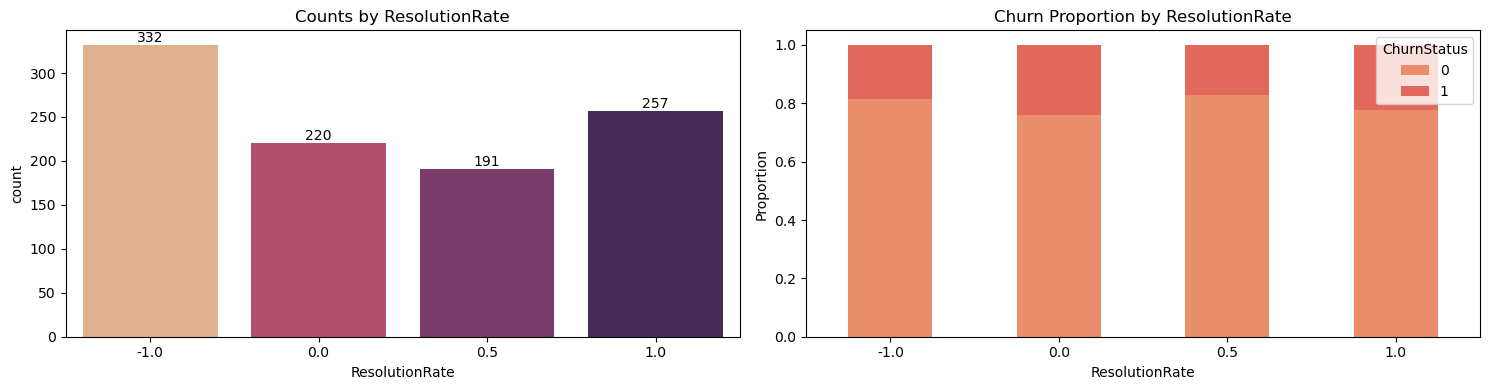

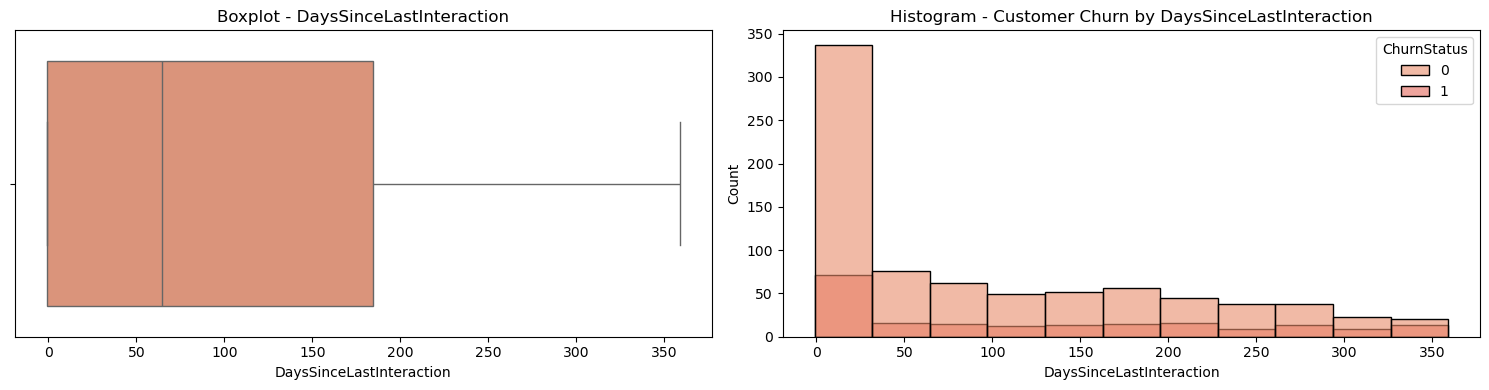

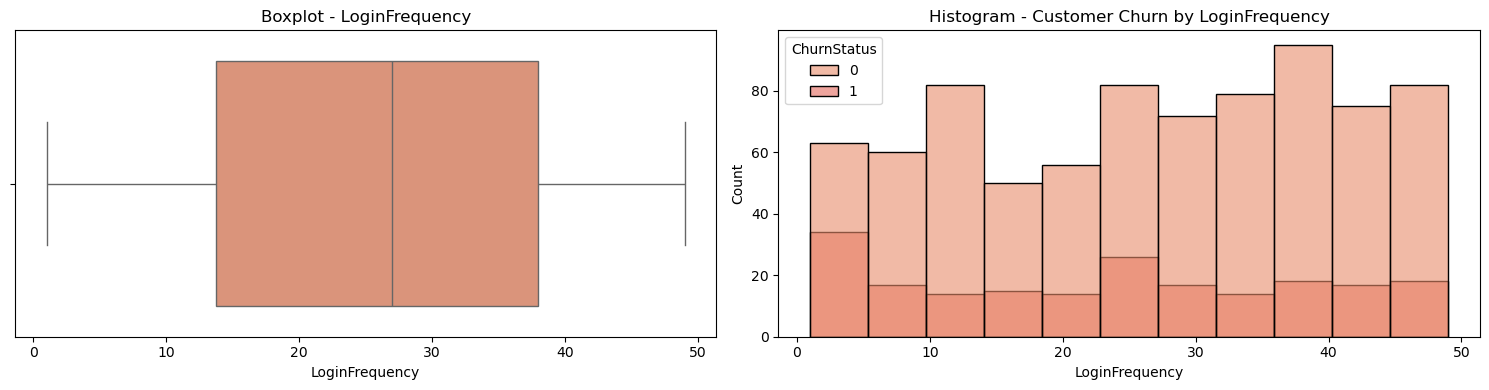

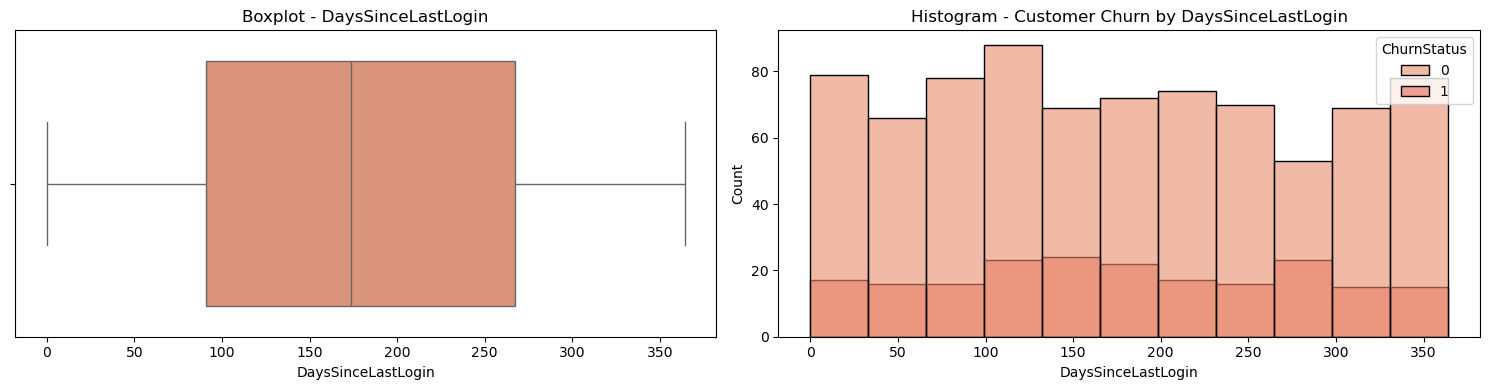

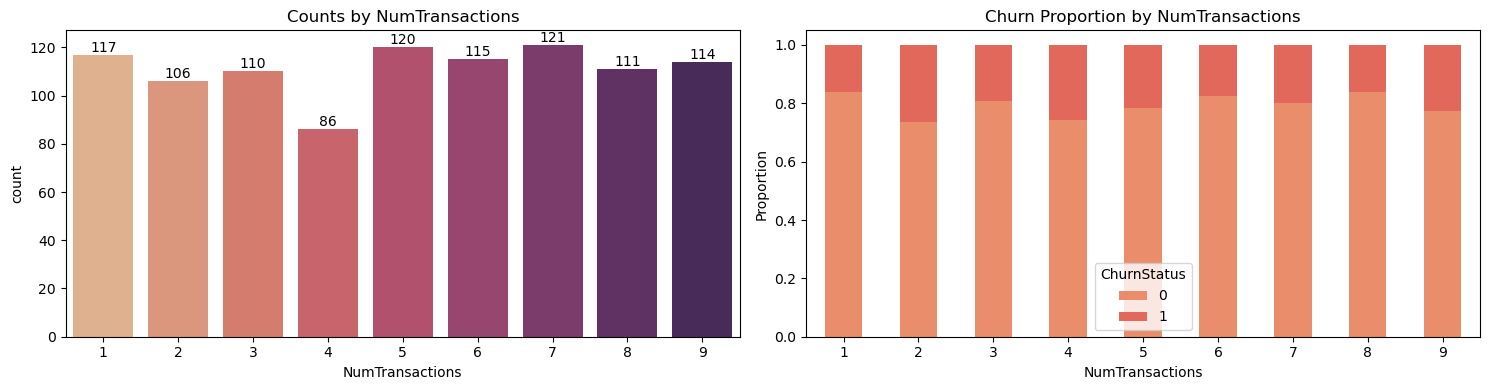

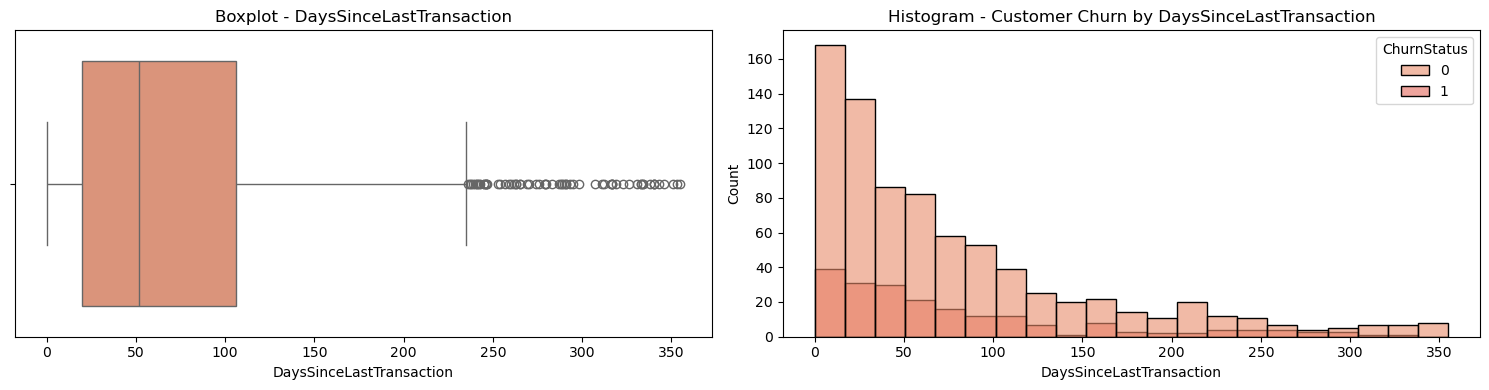

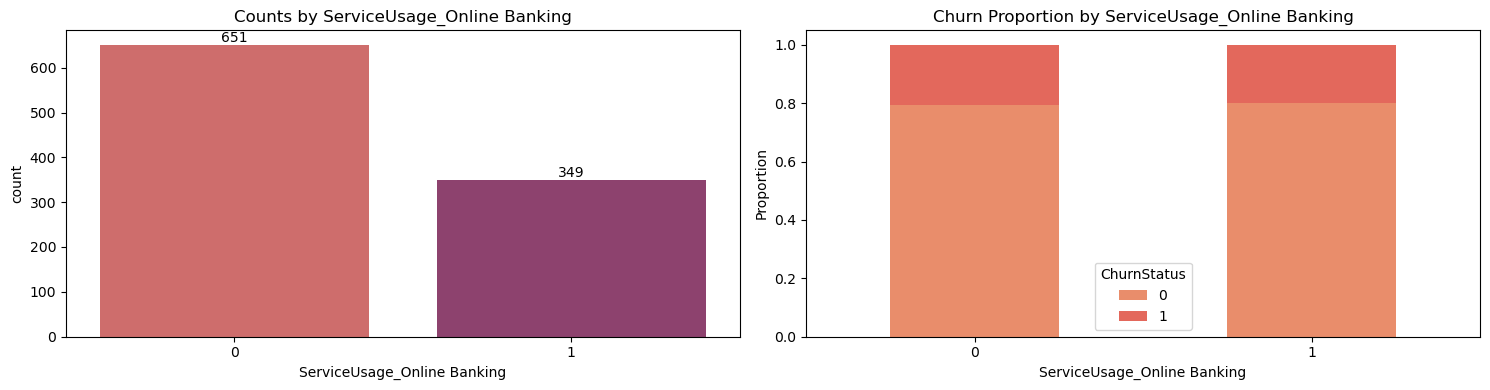

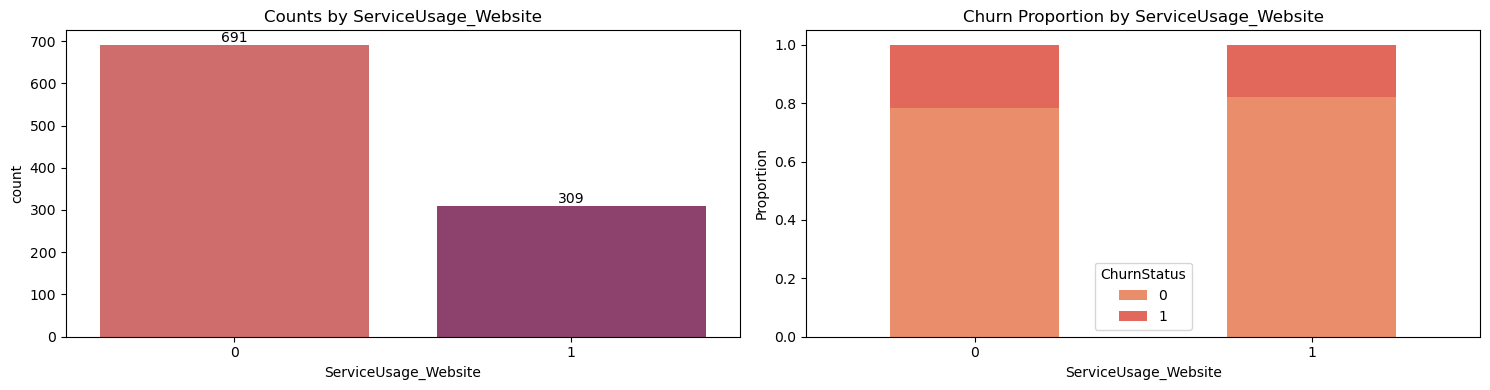

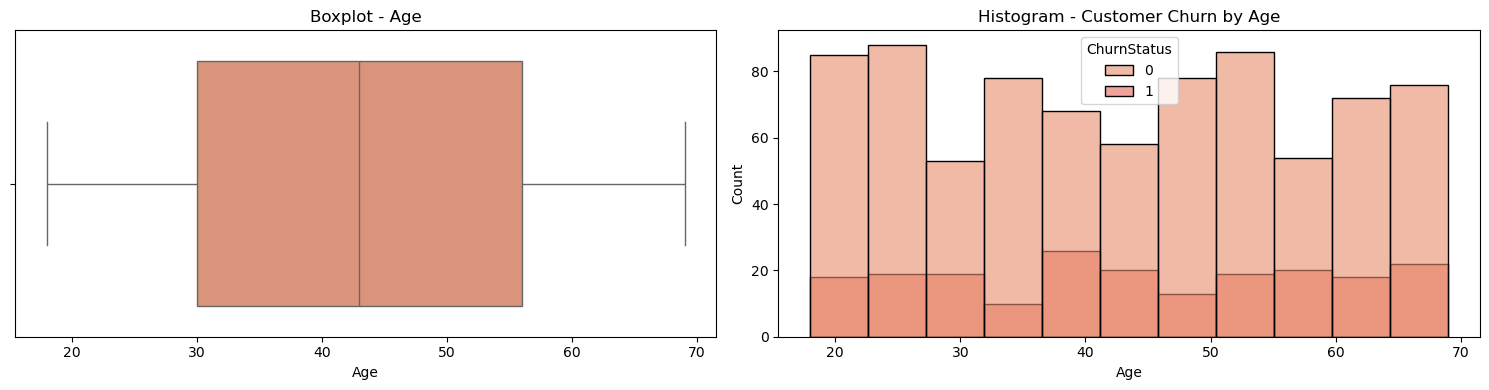

In [83]:
# Plotting
for col in data[numeric_columns].columns:
    if col in lowcardi_vars:
        plot_numeric_lowcardi(data, col)
    elif col in highcardi_vars:
        plot_numeric_highcardi(data, col)

In [84]:
# Checking for outliers
for col in data[numeric_columns].columns:
    q1 = np.percentile(data[col], 25)
    q3 = np.percentile(data[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    outliers = data[col][(data[col] < lower_bound) | (data[col] > upper_bound)]

    print(f'{col}: {len(outliers)} outliers')

ResolutionRate: 0 outliers
DaysSinceLastInteraction: 0 outliers
LoginFrequency: 0 outliers
DaysSinceLastLogin: 0 outliers
NumTransactions: 0 outliers
DaysSinceLastTransaction: 66 outliers
ServiceUsage_Online Banking: 0 outliers
ServiceUsage_Website: 0 outliers
Age: 0 outliers


Insights: 
- ChurnStatus is balanced between categories in all numeric variables indicating that these variables alone may not be good predictors of churn.
- DaysSinceLastTransaction has 66 outliers, however they are valid outliers as there are genuinely customers who have gone a long time without spending. ChurnStatus appears to decrease in proportion with DaysSinceLastTransaction, indicating that this is not a strong predictor.

#### Categorical Variables
We will:
1. Examine the distribution of each categorical variable.
2. Visualize relationships between categorical predictors and the target variable.

In [85]:
data[categorical_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Gender         1000 non-null   object
 1   MaritalStatus  1000 non-null   object
 2   IncomeLevel    1000 non-null   object
dtypes: object(3)
memory usage: 23.6+ KB


In [86]:
data[categorical_columns].describe().T

,count,unique,top,freq
Gender,1000,2,F,513
MaritalStatus,1000,4,Widowed,276
IncomeLevel,1000,3,High,349


In [87]:
# Creating a function to plot categorical variables
def plot_categorical(df, variable, target='ChurnStatus'):

    fig, axs = plt.subplots(1, 2, figsize=(15, 4))

    counts = df[variable].value_counts()
    axs[0].pie(counts.values, labels=counts.index, colors=sns.color_palette('flare'), autopct='%0.2f%%')  

    sns.countplot(data=df, x=variable, hue=target, ax=axs[1], palette=sns.color_palette('flare')[2:4])

    plt.tight_layout()
    plt.show()

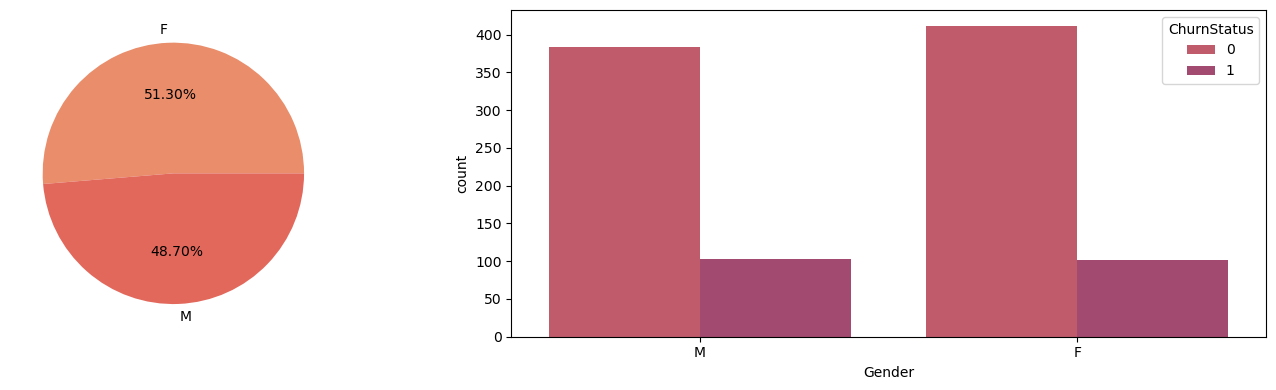

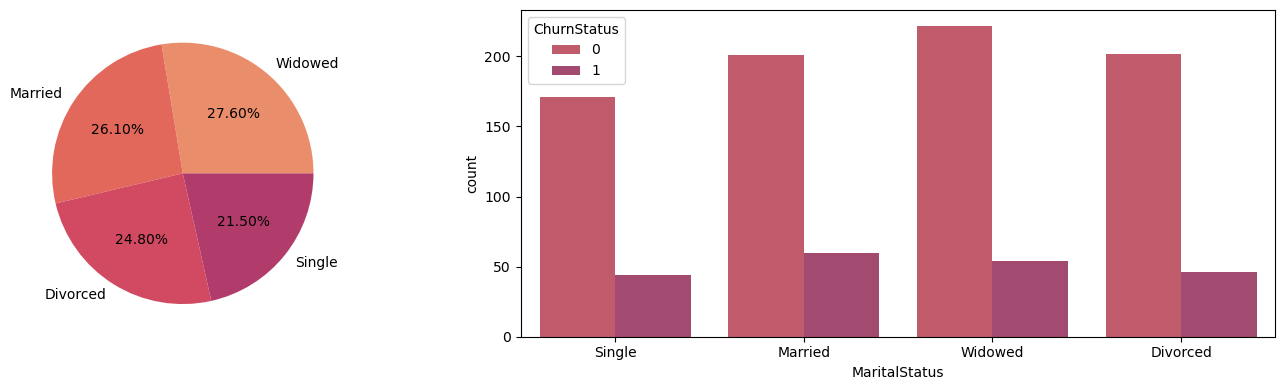

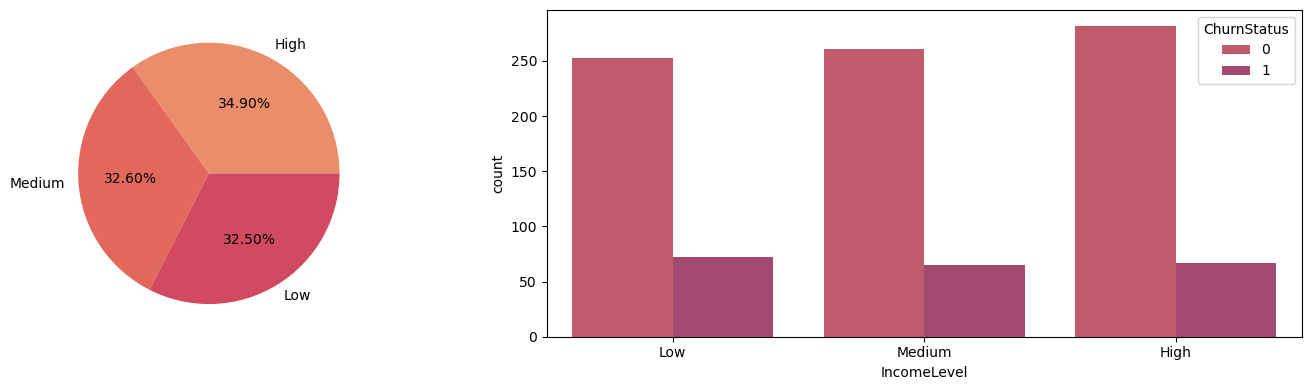

In [88]:
for col in data[categorical_columns].columns:
    if col != 'Age':   # Age is handled separately due to high cardinality
        plot_categorical(data, col)

Insights:
- Categories in these variables appear to be fairly evenly distributed.
- ChurnStatus is fairly balanced between categories in all categorical variables indicating that these variables alone may not be good predictors of churn.
- We will need to numerically encode these variables for modeling.
- We will need to explore multivariate models during our modeling phase to better understand the drivers of churn.

---
### Feature Engineering

In [89]:
from sklearn.feature_selection import mutual_info_classif

In [90]:
X_mi = data.copy()

# Identify categorical columns (object / string)
cat_cols = X_mi.select_dtypes(include=['object', 'string']).columns

# Factorize each categorical column (cheap label encoding) to create discrete features for MI
for col in cat_cols:
    X_mi[col], _ = pd.factorize(X_mi[col])

y = data['ChurnStatus']

In [91]:
# Checking mutual information of features with target variable to determine feature engineering opportunities

mi = mutual_info_classif(X_mi, y, discrete_features=True)
mi_scores = pd.Series(mi, index=X_mi.columns).sort_values(ascending=False)
mi_scores


ChurnStatus                    0.505898
CustomerID                     0.505898
DaysSinceLastLogin             0.203029
DaysSinceLastInteraction       0.173027
DaysSinceLastTransaction       0.134630
LoginFrequency                 0.034852
Age                            0.024498
NumTransactions                0.003730
ResolutionRate                 0.002158
ServiceUsage_Website           0.000949
MaritalStatus                  0.000851
IncomeLevel                    0.000481
Gender                         0.000164
ServiceUsage_Online Banking    0.000019
dtype: float64

- All features have very weak signal with the target variable based on mutual information scores.
- Engineer features that have high mutual information (> 0.005) with the target variable to improve model performance.


In [92]:

data['TransactionsPerLogin'] = data['NumTransactions'] / (data['LoginFrequency'] + 1) # add one to avoid division by zero


In [93]:
# Average days of inactivity across all touchpoints
data['RecencyScore'] = (data['DaysSinceLastTransaction'] + data['DaysSinceLastLogin'] + data['DaysSinceLastInteraction']) / 3

In [94]:
# Activity momentum: Login frequency adjusted by recency score meaning higher values indicate more recent and frequent activity
data['ActivityMomentum'] = data['LoginFrequency'] / (data['RecencyScore'] + 1)

In [95]:
# Re-calculating mi scores

X_mi = data.copy()

# Identify categorical columns (object / string)
cat_cols = X_mi.select_dtypes(include=['object', 'string']).columns

# Factorize each categorical column (cheap label encoding) to create discrete features for MI
for col in cat_cols:
    X_mi[col], _ = pd.factorize(X_mi[col])

y = data['ChurnStatus']

mi = mutual_info_classif(X_mi, y, discrete_features=True)
mi_scores = pd.Series(mi, index=X_mi.columns).sort_values(ascending=False)
mi_scores

ChurnStatus                    0.505898
CustomerID                     0.505898
ActivityMomentum               0.479035
RecencyScore                   0.287283
DaysSinceLastLogin             0.203029
DaysSinceLastInteraction       0.173027
TransactionsPerLogin           0.152655
DaysSinceLastTransaction       0.134630
LoginFrequency                 0.034852
Age                            0.024498
NumTransactions                0.003730
ResolutionRate                 0.002158
ServiceUsage_Website           0.000949
MaritalStatus                  0.000851
IncomeLevel                    0.000481
Gender                         0.000164
ServiceUsage_Online Banking    0.000019
dtype: float64

- The new features ActivityMomentum, RecencyScore, and TransactionPerLogin show higher mutual information scores with the target variable compared to most of the original features. These engineered features capture more complex relationships and behaviors that are more predictive of customer churn.
- We dropped the features with low mutual information scores below 0.02 to reduce noise and improve model performance. These columns included all of our categorical features.
- Our new columns have outliers. And ActivityMomentum and TransactionPerLogin are highly right-skewed. We will need to address this during preprocessing.

In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   1000 non-null   int64  
 1   ChurnStatus                  1000 non-null   int64  
 2   Age                          1000 non-null   int64  
 3   Gender                       1000 non-null   object 
 4   MaritalStatus                1000 non-null   object 
 5   IncomeLevel                  1000 non-null   object 
 6   DaysSinceLastInteraction     1000 non-null   int64  
 7   ResolutionRate               1000 non-null   float64
 8   LoginFrequency               1000 non-null   int64  
 9   ServiceUsage_Online Banking  1000 non-null   int64  
 10  ServiceUsage_Website         1000 non-null   int64  
 11  DaysSinceLastLogin           1000 non-null   int64  
 12  NumTransactions              1000 non-null   int64  
 13  DaysSinceLastTransa

---
### Download Clean Data Set for Modeling

In [97]:
# Let's Save for preprocessing
data.to_csv('../data/clean_customer_churn_data.csv', index=False)

---
### Final Comments:
- EDA and preprocessing are complete. However, EDA insights are inconclusive regarding strong predictors of churn.
- We will need to explore multivariate models during our modeling phase to better understand the drivers of churn.